# LoC Data Package Tutorial: Sanborn Maps collection

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [Sanborn Maps data package](https://data.labs.loc.gov/sanborn/) which is derived from the Library's [Sanborn Maps collection](https://www.loc.gov/collections/sanborn-maps/about-this-collection/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download and display images from a data package](#Download-and-display-images)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First, we will select [Sanborn Maps data package](https://data.labs.loc.gov/sanborn/) and output a summary of it's contents

In [1]:
import io
import json
import math

import boto3                            # for interacting with Amazon S3 (where the data is stored)
import pandas as pd                     # for reading, manipulating, and displaying data

from helpers import get_s3_bucket_stats

BUCKET_NAME = 'loc-sanborn-maps' # The name of public S3 bucket

# Connect to Amazon S3
s3 = boto3.client('s3')

stats = get_s3_bucket_stats(s3, BUCKET_NAME)

# Convert to Pandas DataFrame and show table
pd.DataFrame(stats)

,FileType,Count,Size
0,.jpg,"440,819",148.79GB
1,.zip,76,146.45GB
2,.json,122,436MB
3,.html,65,425MB
4,.txt,61,202MB
5,.jsonl,60,172MB
6,.csv,65,123MB
7,.png,3,198KB
8,.pdf,1,42KB
9,.md,1,35KB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' State values, then filter by a particular State.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [2]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'metadata.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 50,600 entries.


Next let's convert to pandas DataFrame and print the available properties

In [3]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Date, Digitized, Id, IIIF_manifest, Language, Last_updated_in_api, Location_text, City_text, County_text, State_text, Country_text, Location_secondary_text, Mime_type, Notes, Number_of_files, Online_format, Original_format, Part_of, Preview_url, Repository, Source_collection, Subject_headings, Title, Type_of_resource, Location


Next print the top 10 most frequent States in this dataset

In [4]:
# Since "State_text" is a list, we must "explode" it so there's just one state per row
# We convert to DataFrame so it displays as a table
df['State_text'].explode().value_counts().iloc[:10].to_frame()

,count
State_text,
New York,3693
Pennsylvania,3056
Illinois,2878
California,2641
Ohio,2412
Texas,2238
Michigan,1962
Indiana,1709
Oklahoma,1707


Now we filter the results to only those items with State "Oklahoma"

In [5]:
df_by_state = df.explode('State_text')
subset = df_by_state[df_by_state.State_text == 'Oklahoma']
print(f'Found {subset.shape[0]:,} items with state "Oklahoma"')

Found 1,707 items with state "Oklahoma"


## Download and display images

Finally we will download and display the images associated with the first item in the Oklahoma subset.

First, we download the file manifest to retrieve the image filenames associated with the records

In [6]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'manifest.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
files = [dict(zip(data["cols"], row)) for row in data["rows"]] # zip columns and rows
print(f'Loaded manifest file with {len(files):,} entries.')

Loaded manifest file with 607,892 entries.


Next we will retrieve the image filenames associated with the first record in our subset.

In [7]:
item = subset.iloc[0]
item_id = item["Id"]
item_image_files = [file for file in files if file["item_id"] == item_id]
found_count = len(item_image_files)
print(f"Found {found_count:,} image files for {item_id}")

Found 4 image files for http://www.loc.gov/item/sanborn06968_001/


Finally, let's output the first four images as a grid

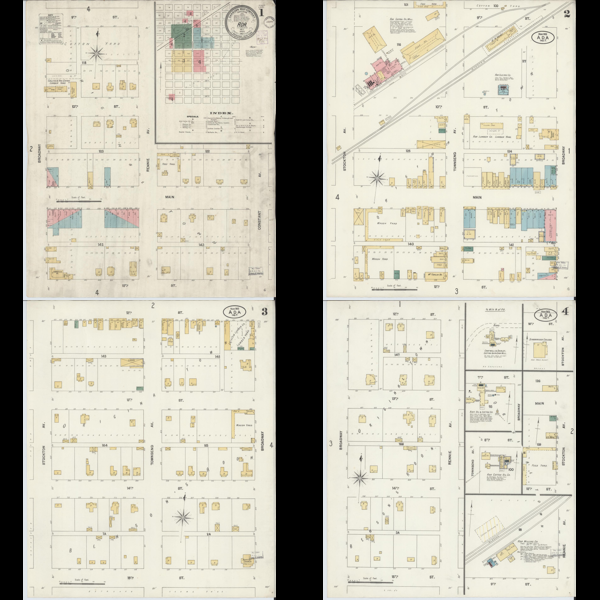

In [8]:
from IPython.display import display     # for displaying images
from PIL import Image                   # for creating, reading, and manipulating images

# Define image dimensions
image_w = 600
image_h = 600
cols = math.ceil(found_count / 2.0)
rows = math.ceil(found_count / 2.0)
cell_w = image_w / cols
cell_h = image_h / rows

# Create base image
base_image = Image.new("RGB", (image_w, image_h))

# Loop through image URLs
for i, file in enumerate(item_image_files):
    # Downoad the image to memory
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'maps-by-state/{file["filename"]}')
    image_filestream = io.BytesIO(obj.get('Body').read())

    # And read the image data
    im = Image.open(image_filestream)

    # Resize it as a thumbnail
    im.thumbnail((cell_w, cell_h))
    tw, th = im.size

    # Position it
    col = i % cols
    row = int(i / cols)
    offset_x = int((cell_w - tw) * 0.5) if tw < cell_w else 0
    offset_y = int((cell_h - th) * 0.5) if th < cell_h else 0
    x = int(col * cell_w + offset_x)
    y = int(row * cell_h + offset_y)

    # Paste it
    base_image.paste(im, (x, y))

# Display the result
display(base_image)